In [118]:
import pandas as pd
from prophet import Prophet
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA,ARMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
import warnings
#import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error

In [119]:
veg = str(input("Enter the commodity = "))

Enter the commodity =  Cabbage


In [120]:
market = str(input("Enter the market = "))

Enter the market =  Bowenpally


In [121]:
print(veg)

Cabbage


In [122]:
print(market)

Bowenpally


In [123]:
dt = pd.date_range(start ='08-01-2023', end ='31-07-2024', freq ='D' )
dt

DatetimeIndex(['2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04',
               '2023-08-05', '2023-08-06', '2023-08-07', '2023-08-08',
               '2023-08-09', '2023-08-10',
               ...
               '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25',
               '2024-07-26', '2024-07-27', '2024-07-28', '2024-07-29',
               '2024-07-30', '2024-07-31'],
              dtype='datetime64[ns]', length=366, freq='D')

In [124]:
df = pd.read_excel('Book.xlsx',parse_dates=['Reported Date'],sheet_name = veg, index_col = 'Reported Date')

In [125]:
df.head()

,State Name,District Name,Market Name,Variety,Group,Arrivals (Tonnes),Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
Reported Date,,,,,,,,,
2023-07-01,Telangana,Hyderabad,Bowenpally,Cabbage,Vegetables,133.0,400,1500,1225
2023-07-02,Telangana,Hyderabad,Bowenpally,Cabbage,Vegetables,160.4,600,1500,1275
2023-07-03,Telangana,Hyderabad,Bowenpally,Cabbage,Vegetables,217.5,600,1500,1275
2023-07-04,Telangana,Hyderabad,Bowenpally,Cabbage,Vegetables,159.4,500,1500,1250
2023-07-05,Telangana,Hyderabad,Bowenpally,Cabbage,Vegetables,185.0,500,1400,1175


In [126]:
df1_price_new = pd.DataFrame(columns=['Market Name','Max Price (Rs./Quintal)'],data=df,index=dt)

In [127]:
df1_price_new.head()

,Market Name,Max Price (Rs./Quintal)
2023-08-01,Bowenpally,1800.0
2023-08-02,Bowenpally,1600.0
2023-08-03,Bowenpally,1600.0
2023-08-04,Bowenpally,1600.0
2023-08-05,Bowenpally,2000.0


In [128]:
df1_price_new['Market Name'].fillna(market,inplace=True)

In [129]:
df1_price_new['Max Price (Rs./Quintal)'].fillna(method='bfill',inplace=True)
df1_price_new['Max Price (Rs./Quintal)'].fillna(method='ffill',inplace=True)

In [130]:
df1_price_new.isnull().sum()

Market Name                0
Max Price (Rs./Quintal)    0
dtype: int64

In [131]:
df1_price = pd.DataFrame(columns=['Market Name','Max Price (Rs./Quintal)'],data=df1_price_new)

In [132]:
df1_price = df1_price.reset_index()

In [133]:
target = pd.DataFrame()

In [134]:
df1_price.rename({'Market Name':'Market'},axis=1,inplace=True)

In [135]:
df1_price = df1_price.rename({'Max Price (Rs./Quintal)':'y','index':'ds'},axis=1)
df1_price.head()

,ds,Market,y
0,2023-08-01,Bowenpally,1800.0
1,2023-08-02,Bowenpally,1600.0
2,2023-08-03,Bowenpally,1600.0
3,2023-08-04,Bowenpally,1600.0
4,2023-08-05,Bowenpally,2000.0


In [136]:
Markets = df1_price.groupby('Market')

In [137]:
df1_price['cap'] = min(df1_price['y']) + max(df1_price['y'])

In [138]:
df1_price['floor'] = min(df1_price['y']) / 2

12:08:40 - cmdstanpy - INFO - Chain [1] start processing
12:08:40 - cmdstanpy - INFO - Chain [1] done processing


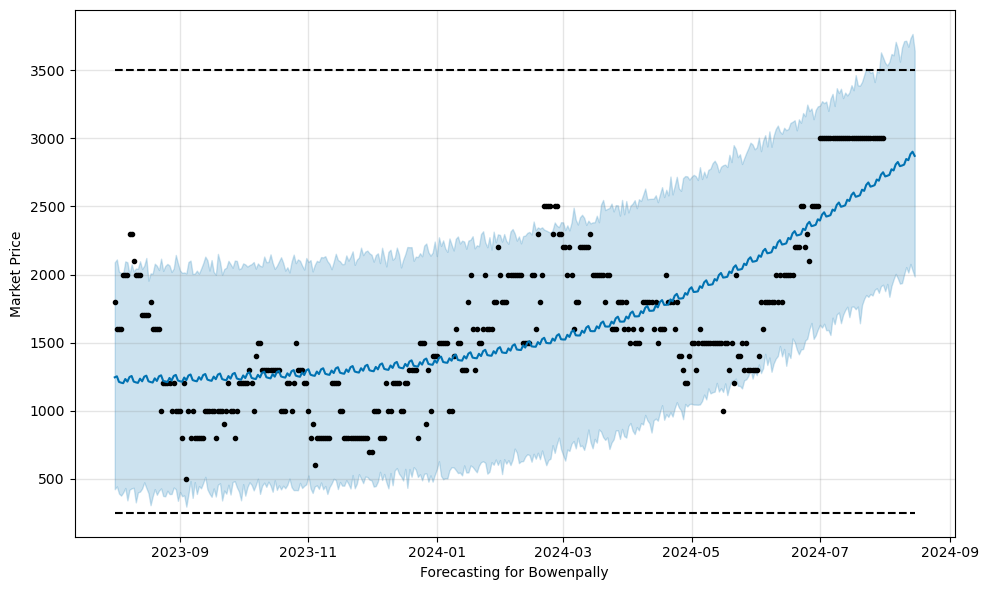

In [139]:
for Market in Markets.groups:
    group = Markets.get_group(Market)
    m = Prophet(growth='logistic',interval_width=0.95, weekly_seasonality=True,daily_seasonality=True,seasonality_mode='additive')
    #m = Prophet(growth='logistic',interval_width=0.95,daily_seasonality=True,weekly_seasonality=True,seasonality_mode='additive')    
    m.fit(group)
    future = m.make_future_dataframe(periods=15)
    future['cap'] = min(df1_price['y']) + max(df1_price['y'])
    future['floor'] = min(df1_price['y']) / 2
    #print(future)
    forecast = m.predict(future)   
    m.plot(forecast,xlabel='Forecasting for '+ Market,ylabel='Market Price')
    forecast = forecast.rename(columns=({'yhat':'yhat_'+ 'Market_Price'}))
    target = pd.merge(target,forecast.set_index('ds'),how='outer',left_index=True,right_index=True)

In [140]:
target

,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat_Market_Price
ds,,,,,,,,,,,,,,,,,,,,
2023-08-01,272.342134,3500.0,250.0,423.155925,2089.806646,272.342134,272.342134,972.716550,972.716550,972.716550,949.9985,949.9985,949.9985,22.718050,22.718050,22.718050,0.0,0.0,0.0,1245.058684
2023-08-02,272.638573,3500.0,250.0,443.866992,2110.724342,272.638573,272.638573,979.912020,979.912020,979.912020,949.9985,949.9985,949.9985,29.913520,29.913520,29.913520,0.0,0.0,0.0,1252.550593
2023-08-03,272.938918,3500.0,250.0,390.822248,2019.925945,272.938918,272.938918,938.463171,938.463171,938.463171,949.9985,949.9985,949.9985,-11.535329,-11.535329,-11.535329,0.0,0.0,0.0,1211.402089
2023-08-04,273.243218,3500.0,250.0,376.023262,2012.318398,273.243218,273.243218,932.472283,932.472283,932.472283,949.9985,949.9985,949.9985,-17.526217,-17.526217,-17.526217,0.0,0.0,0.0,1205.715501
2023-08-05,273.551526,3500.0,250.0,398.858118,2007.150284,273.551526,273.551526,928.371600,928.371600,928.371600,949.9985,949.9985,949.9985,-21.626900,-21.626900,-21.626900,0.0,0.0,0.0,1201.923126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-11,1889.869364,3500.0,250.0,2054.589815,3717.364890,1889.865870,1889.873481,958.781491,958.781491,958.781491,949.9985,949.9985,949.9985,8.782991,8.782991,8.782991,0.0,0.0,0.0,2848.650855
2024-08-12,1900.658290,3500.0,250.0,2014.541029,3673.476586,1900.654241,1900.662913,939.272384,939.272384,939.272384,949.9985,949.9985,949.9985,-10.726116,-10.726116,-10.726116,0.0,0.0,0.0,2839.930674
2024-08-13,1911.444954,3500.0,250.0,2077.614122,3735.353056,1911.440312,1911.450310,972.716550,972.716550,972.716550,949.9985,949.9985,949.9985,22.718050,22.718050,22.718050,0.0,0.0,0.0,2884.161504


In [141]:
target['yhat_Market_Price']

ds
2023-08-01    1245.058684
2023-08-02    1252.550593
2023-08-03    1211.402089
2023-08-04    1205.715501
2023-08-05    1201.923126
                 ...     
2024-08-11    2848.650855
2024-08-12    2839.930674
2024-08-13    2884.161504
2024-08-14    2902.140426
2024-08-15    2871.470867
Name: yhat_Market_Price, Length: 381, dtype: float64

In [142]:
Price = pd.DataFrame(data=target['yhat_Market_Price'])

In [143]:
Price.tail(15)

,yhat_Market_Price
ds,
2024-08-01,2720.528033
2024-08-02,2725.296423
2024-08-03,2731.962247
2024-08-04,2773.144929
2024-08-05,2764.413953
2024-08-06,2808.640643
2024-08-07,2826.622081
2024-08-08,2795.961695
2024-08-09,2800.760812


In [144]:
def mape(actual,pred):
    actual, pred = np.array(actual),np.array(pred)
    return np.mean(np.abs((actual-pred)/actual))*100

In [145]:
mape_min_price = mape(df1_price_new['Max Price (Rs./Quintal)'],Price['yhat_Market_Price'][:df1_price_new.shape[0]])

In [146]:
mape_min_price

24.087767897974057